# LikeToHear AI
liketohear-ai is a prototype that was created in the course of the Hack4Ear Hackathon, organized by Fraunhofer IDMT. It is a first draft for the automatic self-fitting of hearing aids. The device learns from the user's feedback and makes suggestions for different sound situations.

**How it works**

To adjust the listening experience, the user uses the new liketohear technology, with which he can conveniently adjust parameters such as gain and timbre using the mobile phone app.

A machine learning model learns from this feedback and gives the user more and more suitable suggestions over time by learning from his preferences for corresponding situations.

## First Data analysis of spectral data

### Data Preparation


In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
def get_decibels(msg):
    levelsum = lambda x: 10**(float(x)/10) #function to add acoustic levels of sound sources
    if "RMS level in dB" in msg:
        decibels_str_list=re.findall("\\[[^\\]]*]",msg)[0][1:-1].split()
        decibels={str(k+1):float(v) for (k,v) in enumerate(decibels_str_list)}

        #decibels["sound pressure level"]=sum(decibels.values())
        decibels["sound pressure level"]=10*math.log10(sum(map(levelsum,decibels.values())))
    else:
        print("unknown message: "+str(msg))
        decibels={}
    return decibels
    
def parse_file(file):
    with open(file) as f:
        j=json.load(f)
        
    measures=[]
    cur_presetx=0
    cur_presety=0
    cur_el={}
    for el in j:
        if "data" in el:
            if "presetx" in el["data"] and "presety" in el["data"]:
                cur_el["presetx"]=el["data"]["presetx"]
                cur_el["presety"]=el["data"]["presety"]
                measures+=[cur_el]    
            else: #intensity data
                decibels=get_decibels(el["msg"])
                el.update(decibels)
                cur_el=el
    return pd.DataFrame(measures)
        
            
            

In [3]:
  
df=pd.DataFrame(parse_file("2019-08-15_KA06AN17.log"))

df["date"]=pd.to_datetime(df["date"])
df.head()

unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl stopped
unknown message: openMHACtrl started
unknown message: openMHACtrl stopped
unknown message: openMHACtrl started
unknown message: openMHACtrl stopped
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started
unknown message: openMHACtrl started


,msg,data,date,userid,1,2,3,4,5,6,7,8,9,10,11,12,sound pressure level,presetx,presety
0,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:34,SE05CE22,69.204376,48.068005,41.675263,41.219086,35.625729,32.635876,64.508827,50.213528,44.078980,44.156056,35.884479,35.619373,70.573560,5,5
1,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:35,SE05CE22,60.891640,57.948959,44.206162,50.713211,50.885311,30.489567,60.643433,47.117806,44.269424,51.155453,43.780674,38.636864,65.464183,5,5
2,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:36,SE05CE22,59.483269,47.487274,40.958046,47.091606,33.074066,32.804009,57.889145,41.047890,43.665131,45.888092,32.704887,30.773039,62.315670,5,5
3,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:37,SE05CE22,63.308010,55.094208,45.193943,39.928375,35.323475,27.942699,62.211937,52.164001,47.498707,41.960297,33.787655,28.658691,66.450090,5,5
4,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:38,SE05CE22,69.323242,68.280571,65.318649,61.703247,37.130554,35.503925,72.684418,76.121513,72.251656,64.250496,44.501244,39.055016,79.963623,5,5


## Results Analysis

Show unique user IDs contained in the dataset.

In [4]:
print("Unique users Ids")
set(df["userid"])

Unique users Ids


{'42', 'CH6US22', 'DefaultUser', 'KA06AN17', 'SE05CE22', 'Silke'}

In [5]:
user_df=df[df["userid"]=="SE05CE22"]
UserID="SE05CE22"

In [6]:
def plot_timeseries(user_df):
    channel="sound pressure level"
    plt.subplot(411)
    plt.title("UserID "+UserID+" Input - Intensity Value for channel "+channel)
    plt.plot(user_df["date"],user_df[channel])
    plt.tight_layout()
    #plt.show()
    plt.subplot(412)
    plt.plot(user_df["date"],user_df["presetx"])
    plt.title("Response - X Value (tonal color)")
    plt.subplot(413)
    plt.title("Response - Y Value (Amplification)")
    plt.plot(user_df["date"],user_df["presety"])

    plt.subplot(414)
    from scipy.signal import savgol_filter
    y_smooth = savgol_filter(user_df["5"], 51, 2)
    plt.plot(user_df["date"],y_smooth)
    plt.title("Savitzky-Golay Filter (Glättung)")
    
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    fig.savefig(UserID+'_timeseries.png', dpi=120)

    
def plot_details(users):
    for user in users:
        user_df=df[df["userid"]==user]
        plot_timeseries(user_df)


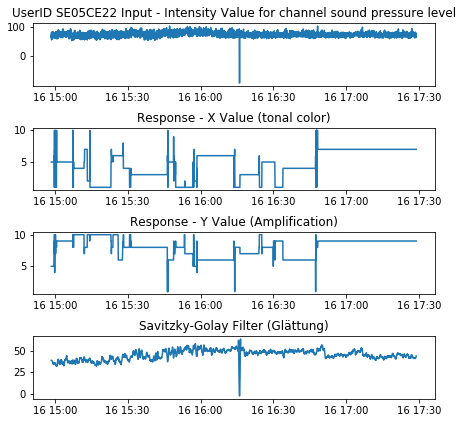

In [8]:
plot_details([UserID])

The X and Y time series plots seem to be correlated. The dynamics of the response evolves on multiple timescales.

### Relation Analysis of Spectrogram and Responses

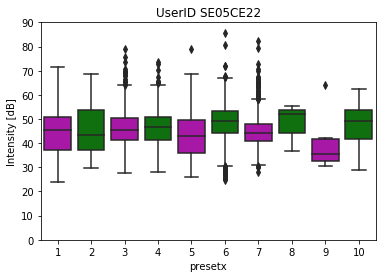

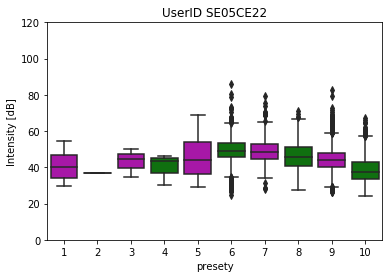

In [9]:
def draw_box_plot():
    pass

from sklearn.preprocessing import RobustScaler
x = user_df[["5","presetx","presety"]].values #returns a numpy array
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled,columns=["5","presetx","presety"])

sns.boxplot(x="presetx",y="5",palette=["m", "g"],
            data=user_df)
plt.title("UserID "+UserID)
plt.ylabel("Intensity [dB]")
plt.ylim(0,90)
fig = plt.gcf()
fig.savefig(UserID+'_boxplotx.png', dpi=100)
plt.show()

sns.boxplot(x="presety",y="5",palette=["m", "g"],
            data=user_df)
plt.title("UserID "+UserID)
plt.ylabel("Intensity [dB]")
plt.ylim(0,120)
fig = plt.gcf()
fig.savefig(UserID+'_boxploty.png', dpi=100)
plt.show()

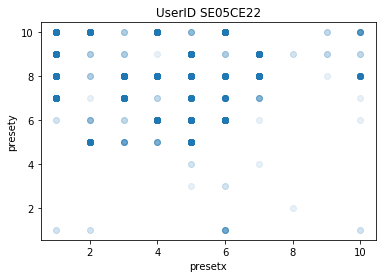

In [10]:
plt.plot(user_df["presetx"],user_df["presety"],'o',alpha=.1)
plt.title("UserID "+UserID)
plt.xlabel("presetx")
plt.ylabel("presety")
fig = plt.gcf()
fig.savefig(UserID+'_presetsmatrix.png', dpi=100)
plt.show()

## Visualization of spectrogram

In [11]:
bands=[]
intensities=[]
dates=[]

def flatten(l):
    return sum(l,[])

for band in range(1,12):
    intensities+=[user_df[str(band)].values]
    bands+=[[band]*len(user_df[str(band)].values)]
    dates+=[range(len(user_df))]

    
intensities=np.array(intensities).flatten()
bands=np.array(bands).flatten()
dates=np.array(dates).flatten()

tmp_df=pd.DataFrame({"intensities":intensities,"bands":bands,"dates":dates})
pv=tmp_df.pivot("bands","dates","intensities")


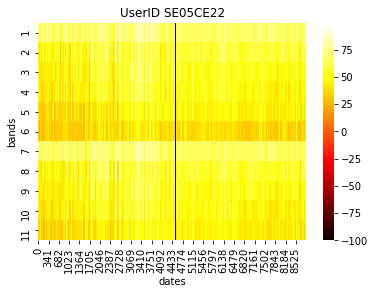

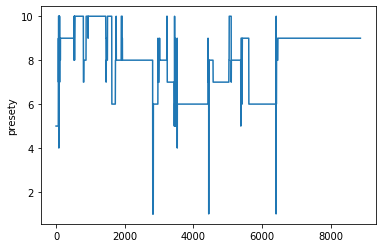

In [12]:
#fig, ax = plt.subplots(2,1, sharex=True)

#ax1=plt.subplot(211)
sns.heatmap(pv,cmap="hot")


#ax2 = plt.subplot(212,sharex=ax1)
#fig = plt.gcf()
#fig.set_size_inches(20,7)

#plt.subplot(212)
plt.title("UserID "+UserID)
fig = plt.gcf()
fig.savefig(UserID+'_heatmap.png', dpi=100)
plt.show()
sns.lineplot(range(len(user_df["date"])),user_df["presety"])

#ax2.plot(range(len(user_df["date"])),user_df["5"])

### Regression Analysis for Self-Fitting of the user

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

X=user_df[["1","2","3","4","5","6","7","8","9"]]
#X=user_df[["5","5"]]
y=user_df["presety"]

X_train=X.iloc[:1000]
y_train=y.iloc[:1000]
X_test=X.iloc[1000:]
y_test=y.iloc[1000:]

#model=DecisionTreeRegressor(max_depth=2)
linear_model=RidgeCV(normalize=True)
linear_model.fit(X_train,y_train)
linear_model.score(X_test,y_test)

-1.018942220928626

Plotting the coefficients of the linear, resembling the relevance of different frequency bands.

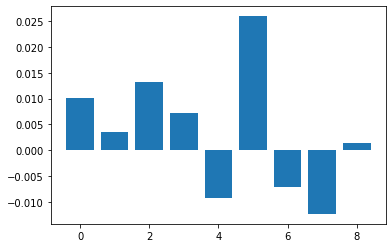

In [14]:
plt.bar(range(len(linear_model.coef_)),linear_model.coef_)
fig = plt.gcf()
fig.savefig(UserID+'_band_relevance.png', dpi=100)


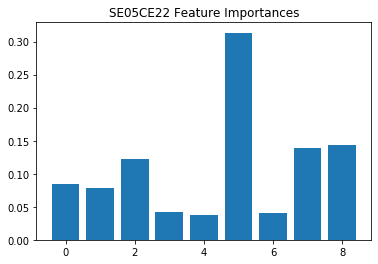

In [15]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(max_depth=3)
model.fit(X_train,y_train)
imps=model.feature_importances_
plt.bar(range(len(imps)),imps)
plt.title(UserID+" Feature Importances")
fig = plt.gcf()
fig.savefig(UserID+'_band_relevance.png', dpi=100)

The feature importance clearly shows the relevance of channels 5,6 which also evident if we look at the pairplot of spectrogram and time series.

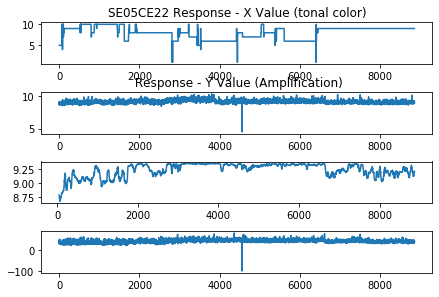

In [16]:
plt.subplot(411)
plt.plot(y)
plt.title(UserID+" Response - X Value (tonal color)")
plt.tight_layout()
plt.subplot(412)
plt.title(" Response - Y Value (Amplification)")
plt.plot(linear_model.predict(X))
plt.subplot(413)
#plt.plot(savgol_filter(model.predict(X),51,2))
plt.plot(pd.Series(model.predict(X)).rolling(50).median())
plt.subplot(414)
plt.plot(user_df["5"].iloc[:])
fig = plt.gcf()
fig.savefig(UserID+'_modelprediction', dpi=100)


In [17]:
from scipy.signal import savgol_filter
y_smooth = savgol_filter(model.predict(X), 31, 2)

# Liketohear-ai Prototype 

In [18]:
from paramiko import SSHClient
client = SSHClient()
client.load_system_host_keys()
client.connect('172.24.1.1',username="pi",password="liketohear")
stdin, stdout, stderr = client.exec_command('ls -l')

ModuleNotFoundError: No module named 'paramiko'

In [19]:
sftp_client = client.open_sftp()
f = sftp_client.open("/media/user_interface.log")

lastLine = None

f.read().decode("utf-8") 
1

NameError: name 'client' is not defined

In [20]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

text=""

while True:
    #time.sleep(5)
    line =f.read().decode("utf-8") 
    text+=line
    
    tmp_text="["+text+"]"
    tmp_text=tmp_text.replace("}\n{","},{")
    print("hi")
    
    j=json.loads(tmp_text)
    

    measures=[]
    cur_presetx=0
    cur_presety=0
    cur_el={}
    for el in j:
        if "data" in el:
            if "presetx" in el["data"] and "presety" in el["data"]:
                cur_el["presetx"]=el["data"]["presetx"]
                cur_el["presety"]=el["data"]["presety"]
                measures+=[cur_el]    
            else: #intensity data
                decibels=get_decibels(el["msg"])
                el.update(decibels)
                cur_el=el
    df=pd.DataFrame(measures)
    user_df=df[df["userid"]=="d"]
    df["date"]=pd.to_datetime(df["date"])

    X=user_df[["1","2","3","4","5","6","7","8","9"]]
    y=user_df["presety"]

    #pred=model.predict(X)
    
    plt.tight_layout()
    plt.subplot(411)
    plt.title("real Y")
    plt.plot(y)
    plt.subplot(412)
    plt.title("Linear model")
    plt.plot(linear_model.predict(X))
    plt.subplot(413)
    plt.title("RandomForestRegressor ")
    #plt.plot(savgol_filter(model.predict(X),51,2))
    plt.plot(pd.Series(model.predict(X)).rolling(2).median())
    #plt.plot(pd.Series(model.predict(X)))
    
    plt.subplot(414)
    plt.title("Intensity")
    plt.plot(user_df["5"].iloc[:])
    #plt.show()
    display.clear_output(wait=True)
    display.display(pl.gcf())
    

NameError: name 'f' is not defined

In [21]:
df

,msg,data,date,userid,1,2,3,4,5,6,7,8,9,10,11,12,sound pressure level,presetx,presety
0,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:34,SE05CE22,69.204376,48.068005,41.675263,41.219086,35.625729,32.635876,64.508827,50.213528,44.078980,44.156056,35.884479,35.619373,70.573560,5,5
1,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:35,SE05CE22,60.891640,57.948959,44.206162,50.713211,50.885311,30.489567,60.643433,47.117806,44.269424,51.155453,43.780674,38.636864,65.464183,5,5
2,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:36,SE05CE22,59.483269,47.487274,40.958046,47.091606,33.074066,32.804009,57.889145,41.047890,43.665131,45.888092,32.704887,30.773039,62.315670,5,5
3,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:37,SE05CE22,63.308010,55.094208,45.193943,39.928375,35.323475,27.942699,62.211937,52.164001,47.498707,41.960297,33.787655,28.658691,66.450090,5,5
4,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-16 14:58:38,SE05CE22,69.323242,68.280571,65.318649,61.703247,37.130554,35.503925,72.684418,76.121513,72.251656,64.250496,44.501244,39.055016,79.963623,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18852,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-06 15:56:45,DefaultUser,66.596748,47.305122,50.295807,37.994812,39.432529,36.161404,66.971039,44.471325,50.570408,42.009296,41.339973,35.750038,69.956938,5,5
18853,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-06 15:56:46,DefaultUser,62.437386,45.822212,46.033001,41.077049,36.234352,32.992226,58.185669,51.220665,49.242516,39.299141,34.850445,33.629909,64.375919,5,5
18854,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-06 15:56:47,DefaultUser,71.400162,56.628662,52.918514,46.432030,34.653553,32.065395,71.708611,60.065804,55.272545,46.998333,39.027992,33.486958,74.877255,5,5
18855,# RMS level in dB\n# vector<float> (monitor)\n...,[],2019-06-06 15:56:48,DefaultUser,67.457230,67.582870,65.576256,61.214565,46.609474,37.678230,69.817345,68.906723,64.357414,65.632080,47.071339,40.152458,76.030836,5,5


In [22]:
# Thanks for the very good organization, 
# meet like-minded people
# Met a lot of interesting people, and am glad to 

x,y => (Poistion vom Bobbel auf der App)
x  .. mehr Höen
y .. Lautstärken

Was will manwissen:
    * Lautstärke vor Verstärkung
    
x,y in Abhängigkeit von Umgebungsssound

Gleiche Soundsituation -> Muster erkennen
Gleiche Soundsituationen ähnlich einstellen?

pro Logging und pro Person 

keine relative Zeit..

SyntaxError: invalid syntax (<ipython-input-22-2f60b1ab9448>, line 5)